In [39]:
import geoengine as ge
from geoengine.workflow_builder.operators import GdalSource, TemporalRasterAggregation, RasterStacker, RenameBands, \
    Expression,RasterTypeConversion, RasterBandDescriptor
import matplotlib.pyplot as plt
import numpy as np
import json

In [40]:
ge.initialize("https://zentrale.app.geoengine.io/api", token="51c46772-6c55-4867-8e42-c9fd8b614820")

In [41]:
marburg_center_utm = [483843.45952547, 5628614.821735]
bbox = ge.BoundingBox2D(
    xmin=marburg_center_utm[0] - 10 * 512,
    xmax=marburg_center_utm[0] + 10 * 512,
    ymin=marburg_center_utm[1] - 10 * 512,
    ymax=marburg_center_utm[1] + 10 * 512,
)
query_rectangle=ge.QueryRectangle(
    spatial_bounds=bbox,
    time_interval=ge.TimeInterval(np.datetime64("2022-07-01T00:00:00")),
    srs='EPSG:32632',
    resolution=ge.SpatialResolution(10, 10),
)

In [42]:
px = 1/plt.rcParams['figure.dpi']  # pixel in inches

In [43]:
rgb = TemporalRasterAggregation(
  aggregation_type='mean',
  granularity='days',
  window_size=5,
  ignore_no_data=True,
  source=RasterStacker(
    sources=[
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`"),
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`"),
      GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`"),
    ],
    rename=RenameBands.rename(['red', 'green', 'blue']),
  )
)

# print(json.dumps(rgb, indent=2))

rgb = ge.register_workflow(rgb)

rgb

1c1f63bb-ec2a-56a9-bacc-3eff598ee7fe

In [44]:
rgb_array = await rgb.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2], # TODO: improve for user, default = all? where are the band names?
)

rgb_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 3, y: 1025, x: 1025)>
array([[[[2632., 2308., 2326., ...,  294.,  161.,  151.],
         [2586., 2338., 2574., ...,  304.,  170.,  168.],
         [2644., 2710., 3030., ...,  418.,  215.,  204.],
         ...,
         [1482., 1378., 1462., ...,  898., 1396., 1350.],
         [1456., 1366., 1438., ...,  996., 1128.,  910.],
         [1372., 1346., 1448., ...,  951.,  716.,  616.]],

        [[2814., 2490., 2444., ...,  447.,  324.,  269.],
         [2820., 2684., 2784., ...,  410.,  296.,  331.],
         [2924., 3054., 3408., ...,  605.,  398.,  386.],
         ...,
         [1011.,  908.,  968., ...,  803., 1158., 1174.],
         [ 988.,  911.,  949., ...,  870., 1026.,  865.],
         [ 932.,  903.,  980., ...,  874.,  735.,  708.]],

        [[2924., 2674., 2600., ...,  278.,  177.,  200.],
         [2916., 2930., 3136., ...,  288.,  185.,  204.],
         [2994., 3396., 3856., ...,  311.,  231.,  238.],
         ...,
         [ 722.,  662.,  695., ...,  542.,  844.,  809.],
         [ 728.,  650.,  689., ...,  628.,  689.,  552.],
         [ 682.,  613.,  673., ...,  642.,  434.,  378.]]]])
Coordinates:
  * x            (x) float64 4.787e+05 4.787e+05 4.787e+05 ... 4.89e+05 4.89e+05
  * y            (y) float64 5.634e+06 5.634e+06 ... 5.624e+06 5.623e+06
  * time         (time) datetime64[ns] 2022-06-27
  * band         (band) int64 0 1 2
    spatial_ref  int64 0

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


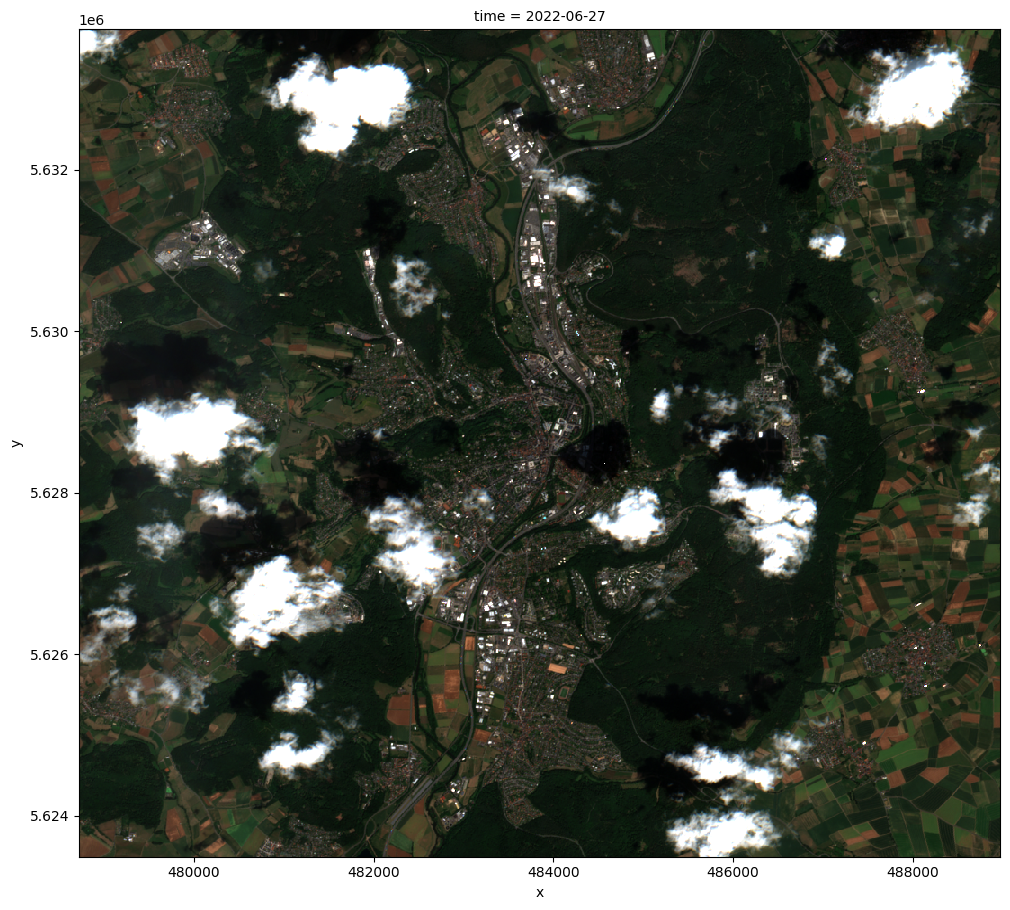

In [45]:
rgb_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
);

In [111]:
def cloud_free(band: GdalSource):
    return Expression(
        # expression = 'if B < 8 { A } else { NODATA }',
        expression = 'if B > 2 && B < 8 { A } else { NODATA }',
        source=RasterStacker(
          sources=[
              band,
              RasterTypeConversion(
                  GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
                  output_data_type='U16',
              ),
          ],
        )
    )

rgb_cloud_free = TemporalRasterAggregation(
  aggregation_type='mean', # 'percentileEstimate',
  # percentile=0.5,
  granularity='months',
  window_size=1,
  ignore_no_data=True,
  source=RasterStacker(
    sources=[
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B04`")),
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")),
      cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B02`")),
    ],
    rename=RenameBands.rename(['red', 'green', 'blue']),
  )
)

# print(json.dumps(rgb, indent=2))

rgb_cloud_free = ge.register_workflow(rgb_cloud_free)

rgb_cloud_free

f8ecb124-0925-5c27-b58a-7c6803467463

In [112]:
rgb_cloud_free_array = await rgb_cloud_free.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0,1,2], # TODO: improve for user, default = all? where are the band names?
)

rgb_cloud_free_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 3, y: 1025, x: 1025)>
array([[[[1421.3334 , 1224.     ,  904.6667 , ...,  455.5    ,
           284.     ,  243.5    ],
         [1274.     ,  921.     ,  528.     , ...,  467.     ,
           274.     ,  291.5    ],
         [1031.6666 ,  669.6667 ,  412.33334, ...,  592.     ,
           384.     ,  322.     ],
         ...,
         [2170.     , 2508.     , 2492.     , ..., 1054.     ,
          1336.     , 1289.     ],
         [2327.3333 , 2651.3333 , 2496.     , ..., 1086.     ,
          1275.     , 1109.5    ],
         [2410.6667 , 2704.6667 , 2515.3333 , ..., 1145.     ,
          1043.     ,  938.     ]],

        [[1224.     , 1104.     ,  922.6667 , ...,  557.     ,
           452.5    ,  424.     ],
         [1120.     ,  908.6667 ,  658.     , ...,  584.     ,
           421.5    ,  437.     ],
         [1024.3334 ,  752.     ,  604.3333 , ...,  693.5    ,
           488.     ,  488.     ],
...
         [1450.6666 , 1680.     , 1666.6666 , ...,  931.5    ,
          1109.     , 1096.     ],
         [1524.     , 1758.     , 1660.3334 , ...,  966.     ,
          1075.     ,  989.     ],
         [1532.6666 , 1760.     , 1673.3334 , ..., 1026.     ,
           914.     ,  872.5    ]],

        [[ 897.3333 ,  799.     ,  631.6667 , ...,  436.     ,
           338.     ,  282.5    ],
         [ 845.     ,  654.6667 ,  421.66666, ...,  385.5    ,
           293.     ,  319.     ],
         [ 713.3333 ,  504.33334,  390.33334, ...,  460.     ,
           395.5    ,  354.     ],
         ...,
         [1014.6667 , 1198.6666 , 1192.6666 , ...,  632.5    ,
           817.5    ,  770.     ],
         [1069.3334 , 1224.6666 , 1175.     , ...,  703.5    ,
           756.     ,  661.5    ],
         [1088.6666 , 1198.6666 , 1148.6666 , ...,  719.5    ,
           599.5    ,  539.     ]]]], dtype=float32)
Coordinates:
  * x            (x) float64 4.787e+05 4.787e+05 4.787e+05 ... 4.89e+05 4.89e+05
  * y            (y) float64 5.634e+06 5.634e+06 ... 5.624e+06 5.623e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0 1 2
    spatial_ref  int64 0

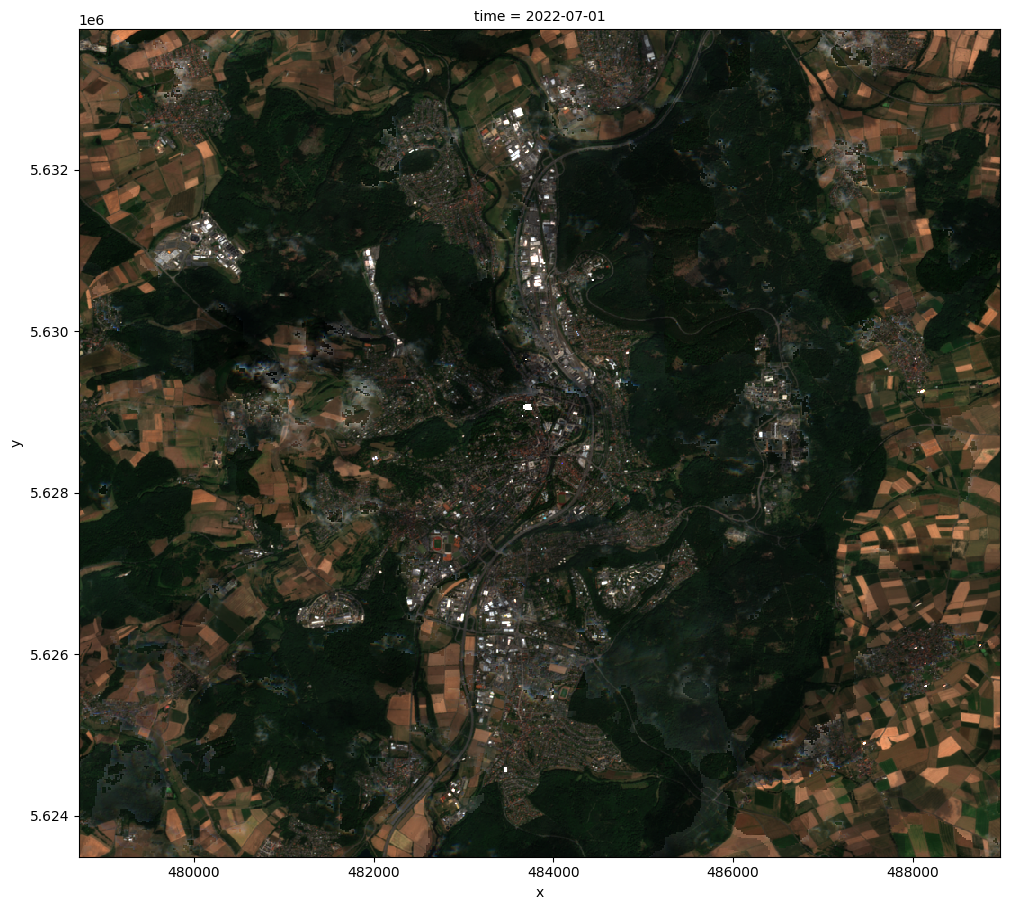

In [114]:
rgb_cloud_free_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
);

In [104]:
'''
water_bodies = Expression(
    expression='if (A-B)/(A+B) > 0.3 { 1 } else { 0 }',
    output_type='U8',
    output_band=RasterBandDescriptor(
        "water bodies",
        measurement=ge.ClassificationMeasurement(
            "water bodies",
            classes={
                0: 'no water',
                1: 'water',
            }
        ),
    ),
    source=TemporalRasterAggregation(
        aggregation_type='mean',
        granularity='months',
        window_size=1,
        ignore_no_data=True,
        source=RasterStacker(
            sources=[
                cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`")),
                cloud_free(GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`")),
            ],
        ),
    ),
)
'''

water_bodies = TemporalRasterAggregation(
    aggregation_type='max',
    granularity='months',
    window_size=9, # 1,
    ignore_no_data=True,
    source=Expression(
        expression='''
            if C >= 8 {
                NODATA
            } else if (A-B)/(A+B) > 0.3 {
                1
            } else {
                0
            }
        ''',
        output_type='U8',
        # output_band=RasterBandDescriptor( # TODO: this is broken in the backend
        #     "water bodies",
        #     measurement=ge.ClassificationMeasurement(
        #         "water bodies",
        #         classes={
        #             0: 'no water',
        #             1: 'water',
        #         }
        #     ),
        # ),
        source=
            RasterStacker(
                sources=[
                    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B03`"),
                    GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:B08`"),
                    RasterTypeConversion(
                        GdalSource("_:5779494c-f3a2-48b3-8a2d-5fbba8c5b6c5:`UTM32N:SCL`"),
                        output_data_type='U16',
                    ),
                ],
            ),
    ),
)

# print(json.dumps(water_bodies.to_workflow_dict(), indent=2))

water_bodies = ge.register_workflow(water_bodies)

water_bodies

9964ed49-5b96-52b9-bd8f-a22928b7b978

In [105]:
water_bodies_array = await water_bodies.raster_stream_into_xarray(
    query_rectangle=query_rectangle,
    clip_to_query_rectangle=True,
    bands=[0], # TODO: improve for user, default = all? where are the band names?
)

water_bodies_array

/home/beilschmidt/git/geoengine-python/env/lib/python3.10/site-packages/rasterio/windows.py:314: RasterioDeprecationWarning: The height, width, and precision parameters are unused, deprecated, and will be removed in 2.0.0.
  warnings.warn(


<xarray.DataArray (time: 1, band: 1, y: 1025, x: 1025)>
array([[[[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]]]], dtype=uint8)
Coordinates:
  * x            (x) float64 4.787e+05 4.787e+05 4.787e+05 ... 4.89e+05 4.89e+05
  * y            (y) float64 5.634e+06 5.634e+06 ... 5.624e+06 5.623e+06
  * time         (time) datetime64[ns] 2022-07-01
  * band         (band) int64 0
    spatial_ref  int64 0

In [106]:
fg = rgb_cloud_free_array.plot.imshow(
    rgb="band",
    col="time",
    vmax=4000,
    size=920*px,
)

cmap = plt.cm.jet
cmap.set_under('white',0.)

for ax in fg.axs:
    water_bodies_array.isel(band=0, time=0, drop=True).plot.imshow(
        cmap=cmap,
        vmin=0.9,
        vmax=1.2,
        ax=ax[0],
    )


NameError: name 'rgb_cloud_free_array' is not defined